In [1]:
from nutils import*
from nutils.pointsseq import PointsSequence
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import colors, collections, cm
import os
import meshio
import vtk
from vtk.util import numpy_support

In [47]:
def GetLumenMesh(fname):
    reader = vtk.vtkXMLUnstructuredGridReader()
    reader.SetFileName(fname)
    reader.Update()
    return reader.GetOutput()

def GetMeshPoints(mesh):
    pts = mesh.GetPoints().GetData()
    pts_array = numpy_support.vtk_to_numpy(pts)
    return pts_array

def GetMeshCells(mesh):
    cells = mesh.GetCells().GetData()
    cells_array = numpy_support.vtk_to_numpy(cells)
    return cells_array
    
def GetMeshData(mesh, data_name):
    data = mesh.GetPointData().GetArray(data_name)
    data_array = numpy_support.vtk_to_numpy(data)
    return data_array

def BuildPlane(origin, normal):
    plane = vtk.vtkPlane()
    plane.SetOrigin(origin)
    plane.SetNormal(normal)
    return plane

def SliceMesh(mesh, plane):
    cutter = vtk.vtkCutter()
    cutter.SetCutFunction(plane)
    cutter.SetInputData(mesh)
    cutter.Update()
    return cutter.GetOutput(0)

def SqrDistance(ptA, ptB):
    return (ptA[0] - ptB[0])**2 + (ptA[1] - ptB[1])**2 + (ptA[2] - ptB[2])**2

def FilterPointsByDistance(mesh, plane, Rmax):
    npts = mesh.GetNumberOfPoints()
    pts_filtered = []
    tractions_filtered = []
    filter_map = [-1] * npts
    k = 0
    for i in range(npts):
        pt = mesh.GetPoint(i)
        sqrdist = SqrDistance(pt, plane.GetOrigin())
        if(sqrdist < Rmax**2):
            traction = mesh.GetPointData().GetArray("Traction").GetValue(i)
            filter_map[i] = k
            k += 1
            pts_filtered.append(pt)
            tractions_filtered.append(traction)
    return np.array(pts_filtered), filter_map

def FilterArray(mesh, data_name, filter_map):
    array = GetMeshData(mesh, data_name)
    n = len(array)
    filtered_array = []
    for i in range(n):
        if filter_map[i] != -1:
            filtered_array.append(array[filter_map[i]])
    return np.array(filtered_array)

def GetFilteredTopology(mesh, filter_map):
    ncells = mesh.GetNumberOfCells()
    connectivity = []
    for i in range(ncells):
        cell = mesh.GetCell(i)
        ids = cell.GetPointIds()
        idA = ids.GetId(0)
        idB = ids.GetId(1)
        if(filter_map[idA] != -1 and filter_map[idB] != -1):
            connectivity.append([filter_map[idA], filter_map[idB]])
    return np.array(connectivity)

def SortPointsByAngle(pts_array):
    pts = pts_array.copy()
    angles = np.zeros([len(pts)])
    u = pts[0]
    u /= np.linalg.norm(u)
    u = np.array([u[0], u[1], 0])
    for i in range(len(pts)):
        v = pts[i]
        v /= np.linalg.norm(v)
        v = np.array([v[0], v[1], 0])
        s = np.sign( CrossProduct(u,v)[2] )
        angles[i] = s * np.arccos(np.clip(v.dot(u),-1,1))
        if s < 0:
            angles[i] += 2 * np.pi
    inds = angles.argsort()
    return inds

def BuildConnectivityArray(npts):
    connectivity = np.zeros([npts,2], dtype=int)
    for i in range(npts):
        connectivity[i] = [i, (i+1) % npts]
    return connectivity

def CrossProduct(u,v):
    wx = (u[1]*v[2]-u[2]*v[1])
    wy = (u[0]*v[2]-u[2]*v[0])
    wz = (u[0]*v[1]-u[1]*v[0])
    return np.array([wx,wy,wz])

def DotProduct(u,v):
    d = 0.0
    for i,j in zip(u,v):
        d += i*j
    return d

def Distance(ptA, ptB):
    return np.sqrt(SqrDistance(ptA,ptB))

def GetTransformationMatrix(plane):
    normal = plane.GetNormal()
    if(normal[0] != 0):
        xaxis = np.array([-(normal[1]+normal[2])/normal[0], 1, 1])
        yaxis = CrossProduct(normal, xaxis)
    elif(normal[1] != 0):
        xaxis = np.array([1, -(normal[0]+normal[2])/normal[1], 1])
        yaxis = CrossProduct(normal, xaxis)
    elif(normal[2] != 0):
        xaxis = np.array([1, 1, -(normal[0]+normal[1])/normal[2]])
        yaxis = CrossProduct(normal, xaxis)
    xaxis /= np.linalg.norm(xaxis)
    yaxis /= np.linalg.norm(yaxis)
    return [xaxis, yaxis]

def TransformVectors(vectors, M):
    transformed_vectors = np.ndarray([vectors.shape[0],vectors.shape[1]-1])
    for i in range(len(vectors)):
        transformed_vectors[i] = [M[0].dot(vectors[i]), M[1].dot(vectors[i])]
    return transformed_vectors
    
def TranslatePoints(pts, plane):
    pts_translated = np.zeros(pts.shape)
    for i in range(len(pts)):
        pts_translated[i] = pts[i] - plane.GetOrigin()
    return pts_translated

def BuildNutilsMesh(pts, connectivity):
    connectivity_sorted = np.sort(connectivity)
    return  mesh.simplex( connectivity_sorted, connectivity_sorted, pts, {}, {}, {} )

def ImmersedArtery(ri, ro, L, E_b, nu_b, E_a, nu_a, E_h, nu_h, pi, Nx, Ny, Nu, p, q, qu, nref, nqref, vals1d, vals2d, res1d = 200, res2d = 3, levels = 50, p_conv = 1, PLOT_LINES = False, delta=0.0, PROJECT_MAT_PROPS=False, p_proj=3,USE_DIRICHLET=False):

    # background mesh
    omega = function.Namespace()
    x = np.linspace(0, L, Nx+1)
    y = np.linspace(0, L, Ny+1)
    omega_topo, omega.x = mesh.rectilinear([x,y])
    
    # Immersed Boundary mesh
    gamma = function.Namespace()
    u = np.linspace(0, np.pi / 2, Nu+1)
    gamma_topo, gamma.u = mesh.rectilinear([u])
    gamma.ri = ri
    gamma.x_i = '<ri cos(u_0), ri sin(u_0)>_i'
    
    # Traction function
    gamma.pi = pi
    gamma.traction_i = '<pi cos(u_0), pi sin(u_0)>_i'

    # Define Mat Props functions
    omega.nu = ArteryMaterialProperty(omega.x[0], omega.x[1], ri, ro, nu_b, nu_a, nu_h)
    omega.E = ArteryMaterialProperty(omega.x[0], omega.x[1], ri, ro, E_b, E_a, E_h)
    omega.mu = 'E / (2 (1 + nu))'
    omega.lmbda = 'E nu / ( (1 + nu) (1 - 2 nu) )'

    # signed distance fields
    omega.sdf = SDF(omega.x[0], omega.x[1], ri, ro, delta)

    # refine background topology for basis
    refined_omega_topo = RefineBySDF(omega_topo, omega.sdf, nref)
    omega.basis = refined_omega_topo.basis('th-spline', degree = p)

    # refine background topology for quadrature rule
    refined_quadrature_topo = RefineBySDF(refined_omega_topo, omega.sdf, nqref)
    gauss_sample = refined_quadrature_topo.sample('gauss', q)
    
    if PROJECT_MAT_PROPS:
        omega.mu = refined_omega_topo.projection(omega.mu, onto=omega.basis, geometry=omega.x, ptype='convolute', ischeme='gauss{}'.format(3*p_proj))
        omega.lmbda = refined_omega_topo.projection(omega.lmbda, onto=omega.basis, geometry=omega.x, ptype='convolute', ischeme='gauss{}'.format(3*p_proj))

    # Build Immersed Boundary Quadrature Rule
    sample_gamma = gamma_topo.sample('gauss', qu)
    sample_omega = locatesample(sample_gamma, gamma.x, refined_omega_topo, omega.x,1e-7)

    # Rebuild traction function on Omega
    omega.traction = sample_omega.asfunction(sample_gamma.eval(gamma.traction))
    omega.Jgamma = sample_omega.asfunction(sample_gamma.eval(function.J(gamma.x)))

    # define analysis
    omega.ubasis = omega.basis.vector(2)
    omega.u_i = 'ubasis_ni ?lhs_n'
    omega.X_i = 'x_i + u_i'
    omega.strain_ij = '(u_i,j + u_j,i) / 2'
    omega.stress_ij = 'lmbda strain_kk δ_ij + 2 mu strain_ij'
    omega.meanstress = 'stress_kk / 3'
    omega.S_ij = 'stress_ij - (stress_kk) δ_ij / 3'
    omega.vonmises = 'sqrt(3 S_ij S_ij / 2)'
    omega.disp = 'sqrt(u_i u_i)'
    omega.r = 'sqrt( x_i x_i )'
    omega.cos = 'x_0 / r'
    omega.sin = 'x_1 / r'
    omega.Qinv_ij = '< < cos , sin >_j , < -sin , cos >_j >_i'
    omega.sigma_kl = 'stress_ij Qinv_kj Qinv_li '
    omega.ubar_i = 'Qinv_ij u_j'
    omega.eps_kl =  'strain_ij Qinv_kj Qinv_li '
    omega.sigmatt = 'sigma_11'
    omega.sigmarr = 'sigma_00'
    omega.ur = 'ubar_0'

    # Stiffness Matrix
    K = gauss_sample.integral('ubasis_ni,j stress_ij d:x' @ omega)

    # Force Vector
    F = sample_omega.integral('traction_i Jgamma ubasis_ni' @ omega)

    # Constrain Omega
    sqr  = refined_omega_topo.boundary['left'].integral('u_0 u_0 d:x' @ omega, degree = 2*p)
    sqr += refined_omega_topo.boundary['bottom'].integral('u_1 u_1 d:x' @ omega, degree = 2*p)
    if USE_DIRICHLET:
        sqr += refined_omega_topo.boundary['top'].integral('u_i u_i d:x' @ omega, degree = 2*p)
        sqr += refined_omega_topo.boundary['right'].integral('u_i u_i d:x' @ omega, degree = 2*p)
    cons = solver.optimize('lhs', sqr, droptol=1e-15)

    # Solve
    lhs = solver.solve_linear('lhs', residual=K-F, constrain=cons)
    
    # plot mesh
    PlotMesh(refined_omega_topo, omega.x, omega.E)
    
    # Post Processing
    smooth_functions = {}

    #Plot 2d
    sample2d = refined_omega_topo.sample('bezier', res2d)
    x_vals = sample2d.eval(omega.x)
    proj_basis = refined_omega_topo.basis('th-spline', degree=p_conv)
    for key in vals2d:
        fig = plt.figure(figsize=(10,10))
        ax = fig.add_subplot(1,1,1)
        fig_contour = plt.figure(figsize=(10,10))
        ax_contour = fig_contour.add_subplot(1,1,1)
        if "_smooth" in key:
            stripped_key = key[0:len(key)-7]
            smooth_functions[key] = refined_omega_topo.projection(stripped_key @ omega(lhs=lhs), onto=proj_basis, geometry=omega.x, ptype='convolute', ischeme='gauss{}'.format(q))
            z = sample2d.eval(smooth_functions[key])
            ax.set_title(stripped_key)
        else:
            z = sample2d.eval(key @ omega, lhs=lhs)
            z[np.logical_or( np.isnan(z) , np.isinf(z) )] = 0
            ax.set_title(key)
        ax_contour.tricontourf(x_vals[:,0], x_vals[:,1], sample2d.tri, z, levels=levels)
        ax.tripcolor(x_vals[:,0], x_vals[:,1], sample2d.tri, z, shading='gouraud', rasterized=True)
        if PLOT_LINES:
            ax.tricontour(x_vals[:,0], x_vals[:,1], sample2d.tri, z, levels=levels)
        plt.show()  
    
    # plot 1d
    results = {}
    
    # Define slice
    s = function.Namespace()
    slice_topo, s.t = mesh.rectilinear([np.linspace(0,L,res1d)]) 
    s.theta = np.pi / 4
    s.x_i = '< t_0 cos(theta), t_0 sin(theta) >_i'
    s.r = 't_0'
    
    # sample 1d
    sample_slice = slice_topo.sample('gauss', 1)
    sample_1d = locatesample(sample_slice, s.x, refined_omega_topo, omega.x, tol=1e-7)
    
    results["r"] = sample_1d.eval(omega.r)
    for key in vals1d:
        if "_smooth" in key:
            stripped_key = key[0:len(key)-7]
            if stripped_key in smooth_functions:
                results[key] = sample_1d.eval(smooth_functions[stripped_key])
            else:
                smooth_functions[stripped_key] = refined_omega_topo.projection(stripped_key @ omega(lhs=lhs), onto=proj_basis, geometry=omega.x, ptype='convolute', ischeme='gauss{}'.format(3*p_conv))
                results[key] = sample_1d.eval(smooth_functions[stripped_key])
        else:
            results[key] = sample_1d.eval(key @ omega, lhs=lhs)
    
    return results

class SDF(function.Pointwise):
    @staticmethod
    def evalf(x,y,ri,ro,delta):
        val0 = (x**2 + y**2 - ri**2) * (1.0 - np.heaviside(x**2 + y**2 - ((ri + ro) / 2)**2, 1))
        val1 = - (x**2 + y**2 - ro**2) * np.heaviside(x**2 + y**2 - ((ri + ro) / 2)**2, 0)
        val3 = val0 * (np.heaviside(x**2 + y**2 - (ri-delta)**2,1)-np.heaviside(x**2 + y**2 - (ri+delta)**2,0))
        val4 = val1 * (np.heaviside(x**2 + y**2 - (ro-delta)**2,1)-np.heaviside(x**2 + y**2 - (ro+delta)**2,0))
        return val0 + val1 - val3 - val4
    def _derivative(self, var, seen):
        return np.zeros(self.shape+var.shape)

class ArteryMaterialProperty(function.Pointwise):
    @staticmethod
    def evalf(x,y,ri,ro,val_b,val_a,val_h):
        val0 = val_b * (1.0 - np.heaviside(x**2 + y**2 - ri**2 ,1))
        val1 = val_a * (np.heaviside(x**2 + y**2 - ri**2 ,1) - np.heaviside(x**2 + y**2 - ro**2 ,0))
        val2 = val_h * (np.heaviside(x**2 + y**2 - ro**2 ,0))
        return val0 + val1 + val2
    def _derivative(self, var, seen):
        return np.zeros(self.shape+var.shape)

def locatesample(fromsample, fromgeom, totopo, togeom, tol, dim=2, **kwargs):
    '''Clone ``fromsample`` onto unrelated topology ``totopo``

    Create a sample ``tosample`` of ``totopo`` such that ``fromgeom`` and
    ``togeom`` are equal on the respective samples and such that integrals are
    equal.

    Parameters
    ----------
    fromsample: :class:`nutils.sample.Sample`
      The sample to be located in ``totopo``.
    fromgeom: :class:`nutils.function.Array`
      The geometry evaluable on ``fromsample``.
    totopo: :class:`nutils.topology.Topology`
      The topology to create ``tosample`` on.
    togeom: :class:`nutils.function.Array`
      The geometry evaluable on ``totopo``.
    **kwargs:
      All keyword arguments are passed to
      :meth:`nutils.topology.Topology.locate`.

    Returns
    -------
    tosample: :class:`nutils.sample.Sample`
      The sample of ``totopo``.

    '''

    tosample = totopo.locate(togeom, fromsample.eval(fromgeom), tol=tol, **kwargs)

    # Copy the weights from `fromsample` and account for the change in local
    # coordinates via the common geometry.
    weights = fromsample.eval(function.J(fromgeom)) / tosample.eval(function.J(togeom))
    for p, i in zip(fromsample.points, fromsample.index):
        weights[i] = p.weights
    weightedpoints = tuple(points.CoordsWeightsPoints(p.coords, weights[i]) for p, i in zip(tosample.points, tosample.index))
    weightedpoints = PointsSequence.from_iter(weightedpoints, dim)
    return sample.Sample.new(tosample.transforms, weightedpoints, tosample.index)

def PlotMesh(topo, geom, f, n=5):
    sample2d = topo.sample('bezier', n)
    xvals = sample2d.eval(geom)
    fvals = sample2d.eval(f)
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(1,1,1)
    ax.set_title("Mesh")
    ax.tripcolor(xvals[:,0], xvals[:,1], sample2d.tri, fvals, shading='gouraud', rasterized=True)
    sample_verts = topo.sample('bezier',2)
    verts = sample_verts.eval(geom)
    ax.add_collection(collections.LineCollection(verts[sample_verts.hull], colors='w', linewidth=0.5, alpha=1))
    plt.show()

def RefineBySDF(topo, sdf, nrefine, dim=2):
    refined_topo = topo
    for n in range(nrefine):
        elems_to_refine = []
        k = 0
        bez = refined_topo.sample('bezier',2)
        sd = bez.eval(sdf)
        sd = sd.reshape( [len(sd)//2**dim, 2**dim] )
        for i in range(len(sd)):
            if np.any(np.not_equal(np.sign(sd[i,:]),np.sign(sd[i,0]))) or np.any(np.equal(np.sign(sd[i,:]),0)):
                elems_to_refine.append(k)
            k = k + 1
        if len(elems_to_refine) != 0:
            refined_topo = refined_topo.refined_by(refined_topo.transforms[np.array(elems_to_refine)])
    return refined_topo

def Plot(figs, plots, xlabels, ylabels, results, exact, legend, COLOR_BY_CASE = True):
    colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
    for fig in figs:
        cit = iter(colors)
        figure = plt.figure(figsize=(10,10))
        ax = figure.add_subplot(1,1,1)
        ax.set_xlabel(xlabels[fig])
        ax.set_ylabel(ylabels[fig])
        ax.set_title(figs[fig])
        label_exact = []
        for plot in plots[fig]:
            if plot in exact:
                label_exact = ["exact"]
                ax.plot(exact["r"], exact[plot], 'k--')
            for col, case in zip(colors,results):
                if COLOR_BY_CASE == False:
                    col = next(cit)
                ax.plot(results[case]["r"], results[case][plot], color=col)
        ax.legend(np.concatenate([label_exact,[case for case in cases]]))
        plt.show()

def Resize(x,n):
    if np.isscalar(x):
        x = [x for i in range(n)]
    if len(x) != n:
        x = [x[0] for i in range(n)]
    return x

def RunImmersedArtery(ri, ro, L, E_b, nu_b, E_a, nu_a, E_h, nu_h, pi, Nx, Ny, Nu, p, q, qu, nref, nqref, vals1d, vals2d, PLOT_LINES = False, delta=0.0, PROJECT_MAT_PROPS=False, p_proj=3,USE_DIRICHLET=False):
    # initialize results
    results = {}
    ncases = len(cases)
    
    # resize input
    ri = Resize(ri,ncases)
    ro = Resize(ro,ncases)
    L = Resize(L,ncases)
    nu_b = Resize(nu_b,ncases)
    E_b = Resize(E_b,ncases)
    nu_a = Resize(nu_a,ncases)
    E_a = Resize(E_a,ncases)
    nu_h = Resize(nu_h,ncases)
    E_h = Resize(E_h,ncases)
    pi = Resize(pi,ncases)
    Nx = Resize(Nx,ncases)
    Ny = Resize(Ny,ncases)
    Nu = Resize(Nu,ncases)
    p = Resize(p,ncases)
    q = Resize(q,ncases)
    qu = Resize(qu,ncases)
    nref = Resize(nref,ncases)
    nqref = Resize(nqref,ncases)
    
    for i in range(ncases):
        results[cases[i]] = ImmersedArtery(ri[i], ro[i], L[i], E_b[i], nu_b[i], E_a[i], nu_a[i], E_h[i], nu_h[i], pi[i], Nx[i], Ny[i], Nu[i], p[i], q[i], qu[i], nref[i], nqref[i], vals1d, vals2d, PLOT_LINES=PLOT_LINES, delta=delta, PROJECT_MAT_PROPS=PROJECT_MAT_PROPS, p_proj=p_proj,USE_DIRICHLET=USE_DIRICHLET)
        print( "Finished case : " + str(cases[i]) )
    
    return results

In [15]:
# Read lumen Mesh Data
fname = "data\\flow_sim.vtu"
lumen_mesh = GetLumenMesh(fname)

In [16]:
# Define Sampling Plane
sampling_plane_origin = (39.35025102748692, -182.88678578819045, 635.1077093084257)
sampling_plane_normal = (0.16669412398742134, -0.9856447804529322, 0.026784991953651572)
sampling_plane = BuildPlane(sampling_plane_origin, sampling_plane_normal)

In [17]:
# Slice Mesh
lumen_mesh_slice = SliceMesh(lumen_mesh, sampling_plane)

In [18]:
# Create Filtered Mesh
R = 4
pts_filtered, fmap = FilterPointsByDistance(lumen_mesh_slice, sampling_plane, R)
tractions_filtered = FilterArray(lumen_mesh_slice, "Traction", fmap)

In [19]:
# transform
M = GetTransformationMatrix(sampling_plane)
pts_translated = TranslatePoints(pts_filtered, sampling_plane)
pts_transformed = TransformVectors(pts_translated, M)
tractions_transformed = TransformVectors(tractions_filtered, M)

In [20]:
# sort
inds = SortPointsByAngle(pts_transformed)
sorted_pts = pts_transformed[inds]
sorted_tractions = tractions_transformed[inds]

In [21]:
# build connectivity
connectivity = BuildConnectivityArray(len(sorted_pts))

In [22]:
# build nutils mesh
gamma = function.Namespace()
gamma_topo, gamma.x = BuildNutilsMesh(sorted_pts, connectivity)

In [23]:
# build traction function
gamma.linbasis = gamma_topo.basis('spline',degree=1)
gamma.tx = gamma.linbasis.dot(sorted_tractions[:,0])
gamma.ty = gamma.linbasis.dot(sorted_tractions[:,1])
gamma.traction_i = '<tx, ty>_i'

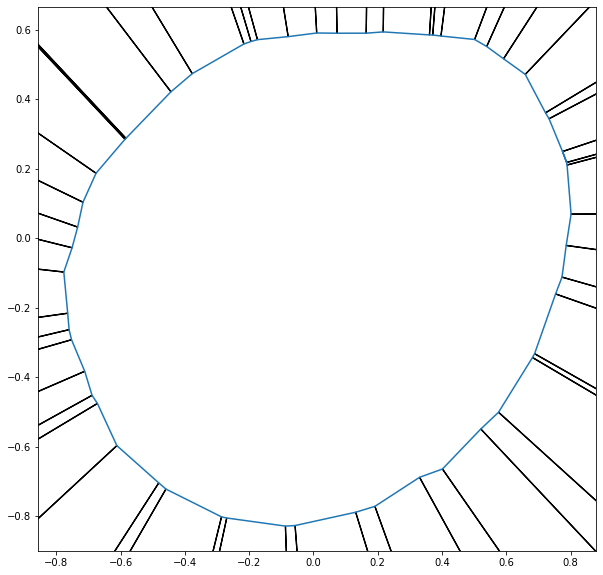

In [24]:
# plot mesh
sample = gamma_topo.sample('bezier',2)
verts = sample.eval(gamma.x)
tvals = sample.eval(gamma.traction)
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(1,1,1)
ax.plot(verts[:,0],verts[:,1])
for i in range(len(tvals)):
    v = tvals[i]
    a = verts[i]
    ax.arrow(a[0], a[1], v[0], v[1])

In [ ]:
def LineLineIntersection(line1, line2):
    # check colinearlity and return False
    
    # Check intersects first vertex, do not check last bc of duplicates
    
    # check interior intersection
    
    

In [45]:
class SDLine(function.Pointwise):
    @staticmethod
    def evalf(x,y, ptAx, ptAy, ptBx, ptBy):
        Lx = ptBx - ptAx
        Ly = ptBy - ptAy
        ax = x - ptAx
        ay = y - ptAy
        s = (ax * Lx + ay * Ly) / np.sqrt(Lx**2 + Ly**2)
        dx = ax - s * Lx
        dy = ay - s * Ly
        d = np.sqrt(np.power(dx,2) + np.power(dy,2))
        sign = Lx * ay - Ly * ax
        return sign * d
    def _derivative(self, var, seen):
        return np.zeros(self.shape+var.shape)

In [154]:
class SDLine(function.Pointwise):
    
    @staticmethod
    def evalf(x,y):
        shape = x.shape
        if shape == ():
            return x
        else:
            vals = np.zeros(shape)
            for i in range(shape[0]):
                val = -1
                for j in range(len(sorted_pts)):
                    ptA = sorted_pts[i]
                    ptB = sorted_pts[(i+1)%len(sorted_pts)]
                    ptAx = ptA[0]
                    ptAy = ptA[1]
                    ptBx = ptB[0]
                    ptBy = ptB[1]
                    Lx = ptBx - ptAx
                    Ly = ptBy - ptAy
                    ax = x[i] - ptAx
                    ay = y[i] - ptAy
                    s = (ax * Lx + ay * Ly) / np.sqrt(Lx**2 + Ly**2)
                    dx = ax - s * Lx
                    dy = ay - s * Ly
                    d = np.sqrt(np.power(dx,2) + np.power(dy,2))
                    sign = Lx * ay - Ly * ax
                    val = max([val, sign * d])
                vals[i] = val
            return vals
                    
                    
    def _derivative(self, var, seen):
        return np.zeros(self.shape + var.shape)

In [213]:
class MeshInclusion(function.Pointwise):
    
    @staticmethod
    def evalf(x,y, L):
        shape = x.shape
        if shape == ():
            return x
        else:
            vals = np.zeros(shape)
            for i in range(shape[0]):
                pt = [x[i] , y[i]]
                if IsInside(sorted_pts, pt, L):
                    vals[i] = -1
                else:
                    vals[i] = 1
            return vals
                    
                    
    def _derivative(self, var, seen):
        return np.zeros(self.shape + var.shape)

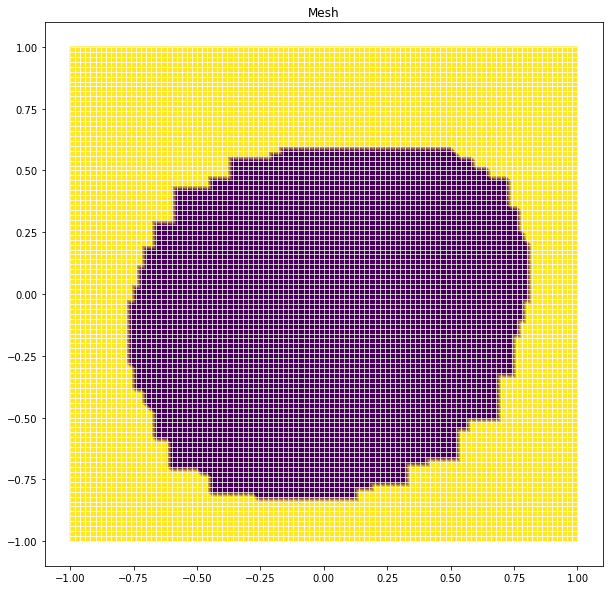

In [217]:
N = 100
x = np.linspace(-1,1,N+1)
ns = function.Namespace()
topo, ns.x = mesh.rectilinear([x,x])
ns.sd = MeshInclusion(ns.x[0], ns.x[1], 2 * (x[-1] - x[0]))
PlotMesh(topo, ns.x, ns.sd, n=2)

In [190]:
sample = topo.sample('bezier',2)
sdvals = sample.eval(ns.sd)
print(sdvals)

[-1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1.  1. -1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1.  1. -1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.  1. -1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.  1. -1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1.  1. -1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1.  1. -1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1. -1. -1. -1. -1. -1. -1. -1

In [56]:
np.mod(2,2)

0

In [153]:
print(max([0,2]))

2


In [101]:
False + 1

1

In [125]:
print( () != () )

False


In [227]:
def IsOnSegment(A,B,C, tol=1e-5):
    mx = (B[0]-A[0]) / (C[0]-A[0])
    my = (B[1]-A[1]) / (C[1]-A[1])
    if abs(mx - my) < tol:
        if mx > 0
    else:
        return False
    
def Orientation(A, B, C):
    val = (B[1] - A[1]) * (C[0]-B[0]) - (B[0]-A[0]) * (C[1]-B[1])
    if val == 0:
        return 0
    if val > 0:
        return 1
    else:
        return 2
    
def LinesDoIntersect(p1, q1, p2, q2):
    o1 = Orientation(p1,q1,p2)
    o2 = Orientation(p1,q1,q2)
    o3 = Orientation(p2,q2,p1)
    o4 = Orientation(p2,q2,q1)
    
    # General Case
    if o1 != o2 and o3 != o4:
        return True
    
    # Special Case: p1, q1, p2 are colinear and p2 lies on line p1q1
    if o1 == 0 and IsOnSegment(p1,p2,q1):
        return True
    # Special Case: p1, q1, q2 are colinear and q2 lies on line p1q1
    if o2 == 0 and IsOnSegment(p1,q2,q1):
        return True
    # Special Case: p2, q2, p1 are colinear and p1 lies on line p1q1
    if o3 == 0 and IsOnSegment(p2,p1,q2):
        return True
    # Special Case: p2, q2, q1 are colinear and q1 lies on line p1q1
    if o4 == 0 and IsOnSegment(p2,q1,q2):
        return True
    return False

def LinesIntersect(p1,q1,p2,q2,debug=False):
    
    # check if first point on edge is intersected
    if IsOnSegment(p1,p2,q1):
        if debug:
            print("Edge Corner is Intersected!")
        return True
    
    # Check General Case    
    o1 = Orientation(p1,q1,p2)
    o2 = Orientation(p1,q1,q2)
    o3 = Orientation(p2,q2,p1)
    o4 = Orientation(p2,q2,q1)
    
    if o1 != o2 and o3 != o4:
        if debug:
            print("Intersects Edge")
        return True
    return False
    
    
def IsInside(pts, pt, L, debug=False):
    line = [[pt[0], pt[1]] , [pt[0] + L, pt[1]]]
    nIntersections = 0
    n = len(pts)
    for i in range(n):
        edge = [pts[i] , pts[(i+1)%n]]
        if IsOnSegment(edge[0], pt, edge[1]):
            if debug:
                print("is On Segment!")
            return True
        else:
            if LinesIntersect(line[0], line[1], edge[0], edge[1], debug=debug):
                nIntersections += 1
    if debug:
        print("Number of intersections: " + str(nIntersections))
    if nIntersections % 2 == 1:
        return True
    else:
        return False

Interesect!


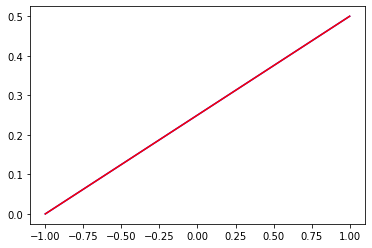

In [172]:
line1 = [[-1, 0.0],  [1, 0.5]]
line2 = [[1.1, 0],  [0, 1]]
line2 = line1


if( LinesDoIntersect(line1[0], line1[1], line2[0], line2[1]) ):
    print("Interesect!")
else:
    print("No Intersection")
    
plt.plot([line1[0][0], line1[1][0]],[line1[0][1], line1[1][1]], 'b')
plt.plot([line2[0][0], line2[1][0]],[line2[0][1], line2[1][1]], 'r')

is On Segment!


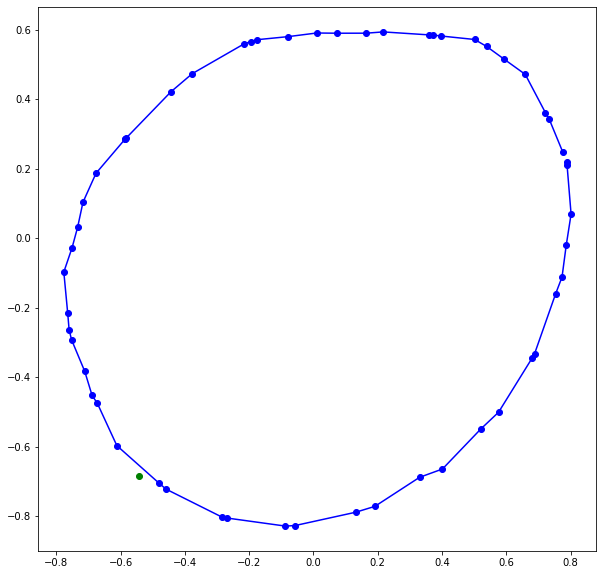

In [235]:
def Remap(val, a1, b1, a2, b2):
    return a2 + (val - a1) / (b1 - a1) * (b2 - a2)


N = 1
debug=True

ax = min(sorted_pts[:,0])
bx = max(sorted_pts[:,0])
ay = min(sorted_pts[:,1])
by = max(sorted_pts[:,1])

fig = plt.figure(figsize=(10,10))
axes = fig.add_subplot(1,1,1)
axes.plot(sorted_pts[:,0], sorted_pts[:,1], '-bo')

for i in range(N):
    r1 = np.random.rand()
    r2 = np.random.rand()
    pt = [Remap(r1, 0, 1, ax, bx), Remap(r2, 0, 1, ay, by)]
    if IsInside(sorted_pts, pt, 10, debug=debug):
        axes.plot(pt[0],pt[1], 'go')
    else:
        axes.plot(pt[0],pt[1], 'ro')



In [201]:
print() 